# Random Forest Classifier for S&P 500 Direction Prediction

This notebook uses the combined S&P 500 dataset (2020-2025) to train a Random Forest Classifier for market direction prediction.

The model will predict whether the S&P 500 will go up (1) or down (0) the next day based on technical indicators.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# 1. Load S&P 500 data from combined CSV
df = pd.read_csv("../Dataset/SP500_combined_2020-2025.csv")

# Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Sort by date in chronological order (oldest to newest)
df = df.sort_index()

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print("\nColumns available:")
print(df.columns.tolist())
print("\nFirst few rows (oldest dates):")
print(df.head())
print("\nLast few rows (newest dates):")
print(df.tail())

# Verify chronological order
print(f"\n✅ Data is sorted chronologically: {df.index.is_monotonic_increasing}")
print(f"Total trading days: {len(df)}")

Dataset shape: (1398, 5)
Date range: 2020-01-02 00:00:00 to 2025-07-25 00:00:00

Columns available:
['Open', 'High', 'Low', 'Close', 'source_file']

First few rows (oldest dates):
                Open      High       Low     Close                 source_file
Date                                                                          
2020-01-02  3,244.67  3,258.14  3,235.53  3,257.85  1_01012020 to 12312020.csv
2020-01-03  3,226.36  3,246.15  3,222.34  3,234.85  1_01012020 to 12312020.csv
2020-01-06  3,217.55  3,246.84  3,214.64  3,246.28  1_01012020 to 12312020.csv
2020-01-07  3,241.86  3,244.91  3,232.43  3,237.18  1_01012020 to 12312020.csv
2020-01-08  3,238.59  3,267.07  3,236.67  3,253.05  1_01012020 to 12312020.csv

Last few rows (newest dates):
                Open      High       Low     Close                 source_file
Date                                                                          
2025-07-21  6,304.74  6,336.08  6,303.79  6,305.60  6_01012025 to 25072025.csv

In [3]:
# 2. Clean and convert numeric columns
# Remove commas and convert to float for all price columns
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']

for col in price_columns:
    if col in df.columns:
        # Convert to string first, remove commas, then convert to float
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Convert Volume to numeric (remove commas if present)
if 'Volume' in df.columns:
    df['Volume'] = df['Volume'].astype(str).str.replace(',', '').astype(float)

print("Data types after conversion:")
print(df.dtypes)
print("\nPrice data sample:")
print(df[['Open', 'High', 'Low', 'Close']].head())

Data types after conversion:
Open           float64
High           float64
Low            float64
Close          float64
source_file     object
dtype: object

Price data sample:
               Open     High      Low    Close
Date                                          
2020-01-02  3244.67  3258.14  3235.53  3257.85
2020-01-03  3226.36  3246.15  3222.34  3234.85
2020-01-06  3217.55  3246.84  3214.64  3246.28
2020-01-07  3241.86  3244.91  3232.43  3237.18
2020-01-08  3238.59  3267.07  3236.67  3253.05


In [4]:
# 2. Feature Engineering - Technical Indicators
df["SMA_10"] = SMAIndicator(close=df["Close"], window=10).sma_indicator()
df["EMA_10"] = EMAIndicator(close=df["Close"], window=10).ema_indicator()
df["RSI"] = RSIIndicator(close=df["Close"], window=14).rsi()

In [5]:
# 3. Create the target: 1 if next day return is positive, else 0
df["Return"] = df["Close"].pct_change()
df["Target"] = (df["Return"].shift(-1) > 0).astype(int)

In [6]:
# 4. Drop missing values
df.dropna(inplace=True)

In [7]:
# 5. Define features and target
features = ["SMA_10", "EMA_10", "RSI"]
X = df[features]
y = df["Target"]

In [8]:
# 6. Train/test split without shuffling (time series)
X_train, X_test = X.iloc[:-100], X.iloc[-100:]
y_train, y_test = y.iloc[:-100], y.iloc[-100:]

In [9]:
# 7. Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
# 8. Make predictions
y_pred = model.predict(X_test)

In [11]:
# 9. Evaluate model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[16 24]
 [28 32]]

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.40      0.38        40
           1       0.57      0.53      0.55        60

    accuracy                           0.48       100
   macro avg       0.47      0.47      0.47       100
weighted avg       0.49      0.48      0.48       100



C:\Users\nattt\AppData\Local\Temp\ipykernel_13748\371466109.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(dates, y_pred, 's-', label="Predicted", linestyle="--", linewidth=2,


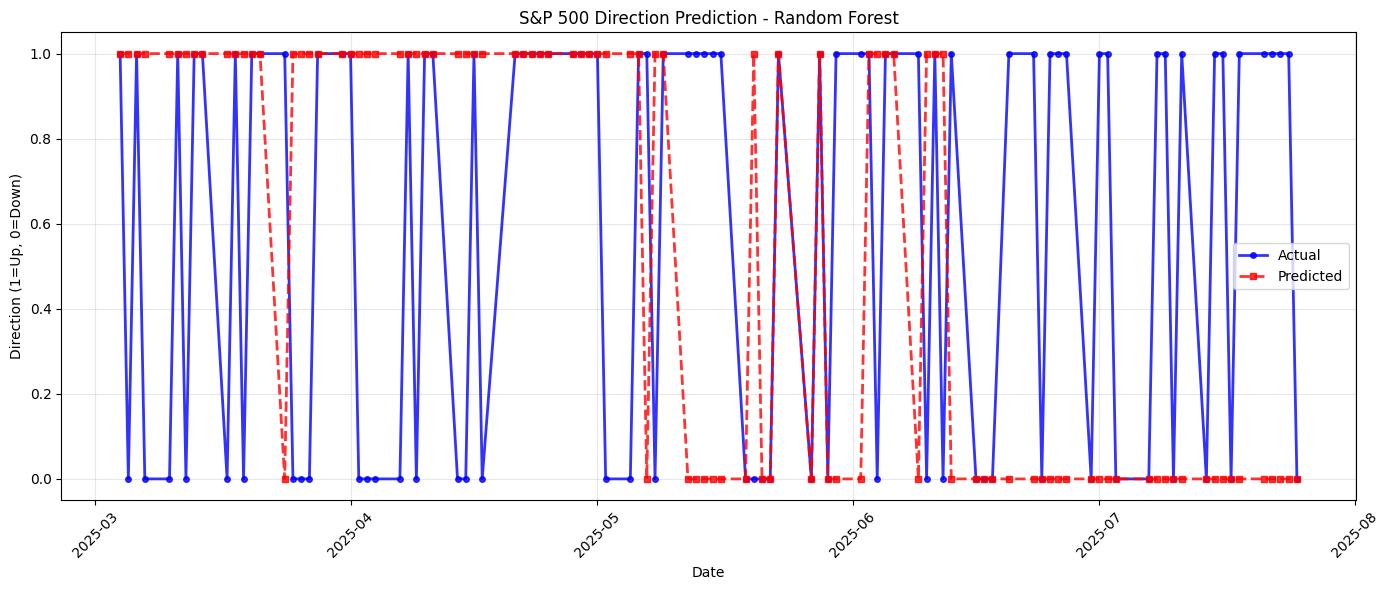

Model Accuracy: 0.480 (48.0%)


In [12]:
# 10. Visualization 1: Time Series Predictions vs Actual
plt.figure(figsize=(14, 6))
dates = y_test.index

plt.plot(dates, y_test.values, 'o-', label="Actual", linewidth=2, alpha=0.8, 
         markersize=4, color='blue')
plt.plot(dates, y_pred, 's-', label="Predicted", linestyle="--", linewidth=2, 
         alpha=0.8, markersize=4, color='red')

plt.title("S&P 500 Direction Prediction - Random Forest")
plt.xlabel("Date")
plt.ylabel("Direction (1=Up, 0=Down)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and display accuracy
accuracy = (y_pred == y_test).mean()
print(f"Model Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

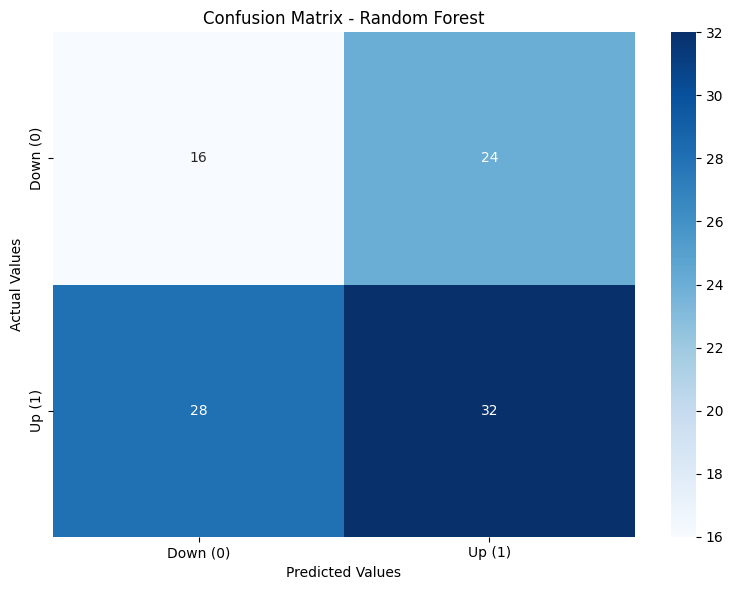

Performance Metrics:
Accuracy: 0.480
Precision: 0.571
Recall: 0.533
F1-Score: 0.552


In [13]:
# 11. Visualization 2: Confusion Matrix Heatmap
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down (0)', 'Up (1)'], yticklabels=['Down (0)', 'Up (1)'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.tight_layout()
plt.show()

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Performance Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

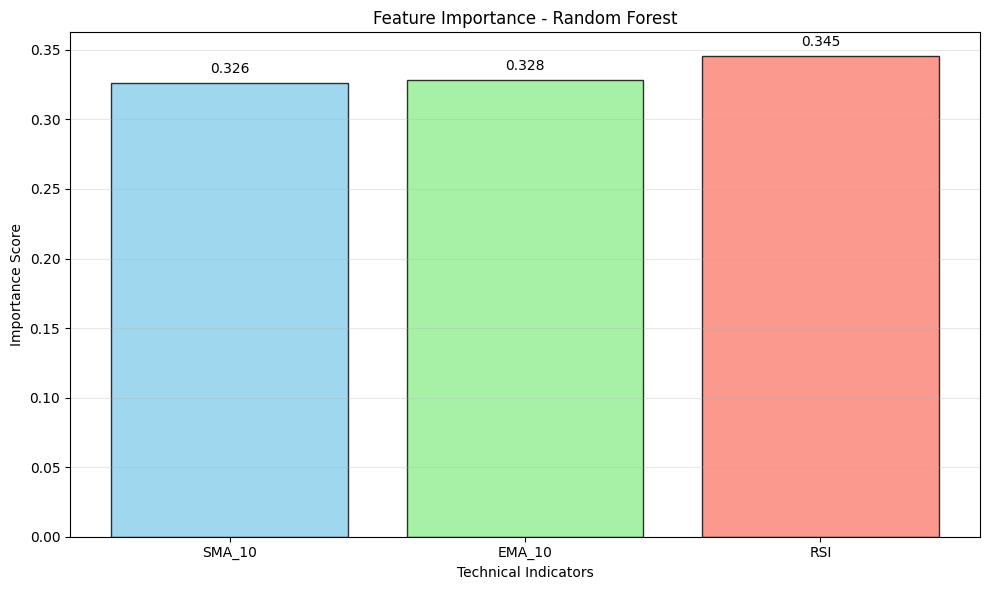

=== Feature Importance Analysis ===
SMA_10: 0.3264 (32.6%)
EMA_10: 0.3283 (32.8%)
RSI: 0.3453 (34.5%)

🔍 Most important feature: RSI


In [14]:
# 12. Visualization 3: Feature Importance
plt.figure(figsize=(10, 6))
feature_importance = model.feature_importances_
colors = ['skyblue', 'lightgreen', 'salmon']

bars = plt.bar(features, feature_importance, color=colors, alpha=0.8, edgecolor='black')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Technical Indicators')
plt.ylabel('Importance Score')
plt.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar, importance in zip(bars, feature_importance):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{importance:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Feature importance analysis
print("=== Feature Importance Analysis ===")
for feature, importance in zip(features, feature_importance):
    print(f"{feature}: {importance:.4f} ({importance/sum(feature_importance)*100:.1f}%)")

most_important = features[np.argmax(feature_importance)]
print(f"\n🔍 Most important feature: {most_important}")

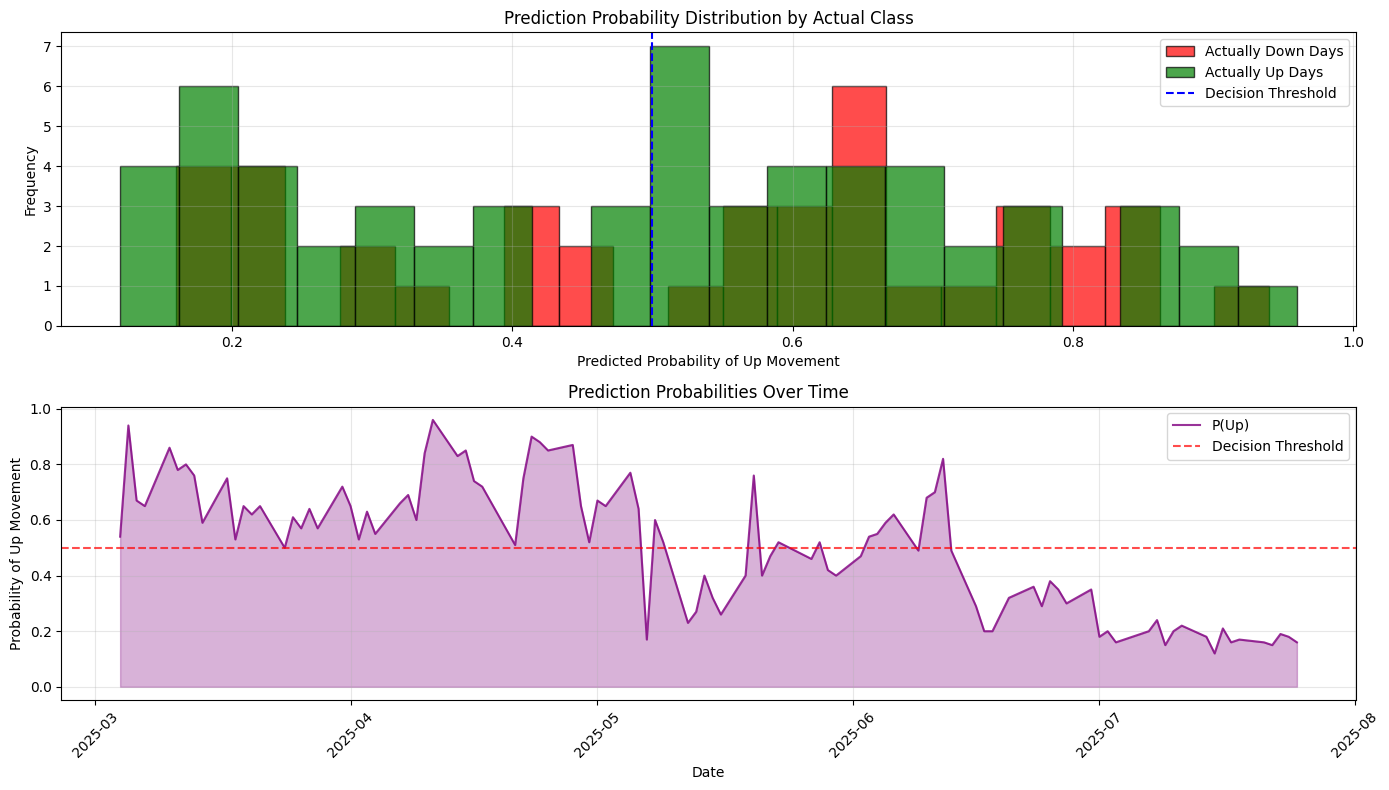

Average probability for down days: 0.530
Average probability for up days: 0.491
Class separation: 0.040


In [15]:
# 13. Visualization 4: Prediction Probabilities
y_pred_proba = model.predict_proba(X_test)

plt.figure(figsize=(14, 8))

# Subplot 1: Probability distribution
plt.subplot(2, 1, 1)
plt.hist(y_pred_proba[y_test == 0, 1], alpha=0.7, label='Actually Down Days', 
         bins=20, color='red', edgecolor='black')
plt.hist(y_pred_proba[y_test == 1, 1], alpha=0.7, label='Actually Up Days', 
         bins=20, color='green', edgecolor='black')
plt.axvline(x=0.5, color='blue', linestyle='--', label='Decision Threshold')
plt.xlabel('Predicted Probability of Up Movement')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution by Actual Class')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Probabilities over time
plt.subplot(2, 1, 2)
dates = y_test.index
prob_up = y_pred_proba[:, 1]

plt.plot(dates, prob_up, label='P(Up)', alpha=0.8, color='purple', linewidth=1.5)
plt.axhline(y=0.5, color='red', linestyle='--', label='Decision Threshold', alpha=0.7)
plt.fill_between(dates, 0, prob_up, alpha=0.3, color='purple')

plt.title('Prediction Probabilities Over Time')
plt.xlabel('Date')
plt.ylabel('Probability of Up Movement')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Probability statistics
prob_down_mean = y_pred_proba[y_test == 0, 1].mean()
prob_up_mean = y_pred_proba[y_test == 1, 1].mean()
print(f"Average probability for down days: {prob_down_mean:.3f}")
print(f"Average probability for up days: {prob_up_mean:.3f}")
print(f"Class separation: {abs(prob_up_mean - prob_down_mean):.3f}")

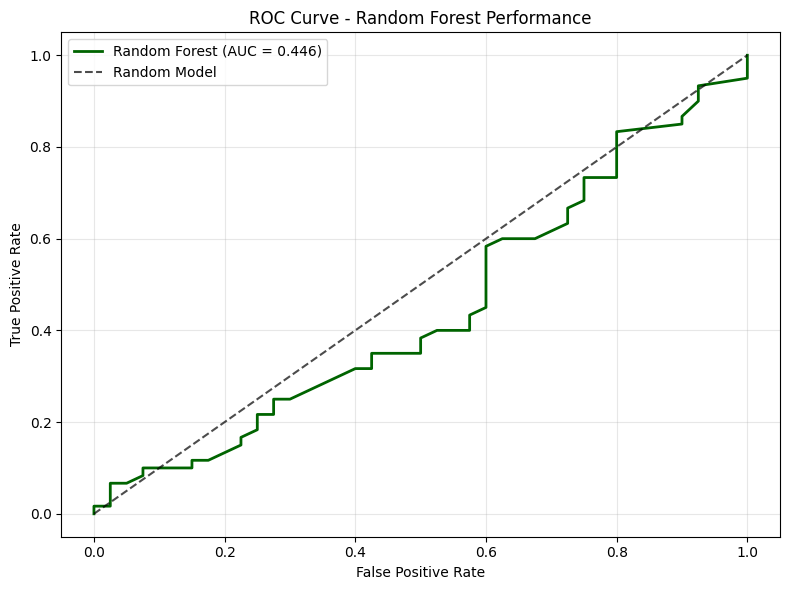

AUC Score: 0.4465
❌ Poor performance


In [16]:
# 14. Visualization 5: ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.3f})', linewidth=2, color='darkgreen')
plt.plot([0, 1], [0, 1], 'k--', label='Random Model', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC Score: {auc_score:.4f}")
if auc_score > 0.7:
    print("✅ Good model performance")
elif auc_score > 0.5:
    print("⚠️ Moderate performance")
else:
    print("❌ Poor performance")

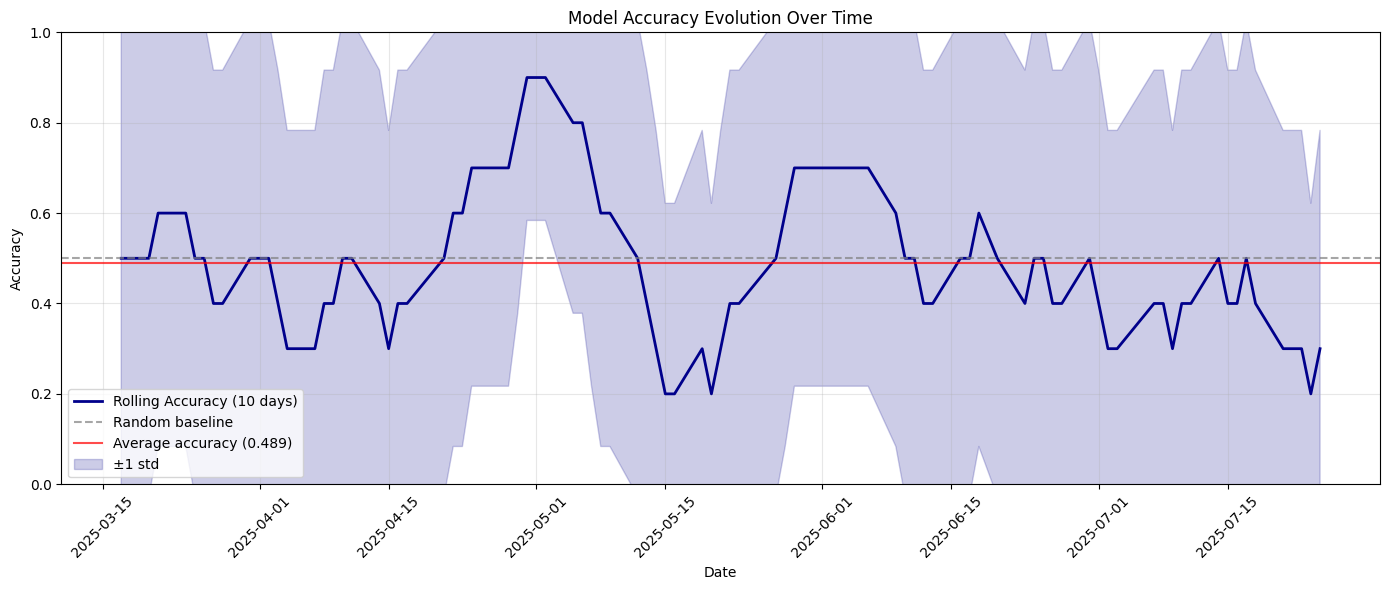

Best 10-day period: 2025-04-30 (Accuracy: 0.900)
Worst 10-day period: 2025-05-15 (Accuracy: 0.200)
Accuracy volatility (std): 0.163


In [17]:
# 15. Visualization 6: Rolling Accuracy Analysis
plt.figure(figsize=(14, 6))

# Calculate rolling accuracy
correct_preds = (y_pred == y_test)
accuracy_timeline = correct_preds.rolling(window=10).mean()
dates = y_test.index

plt.plot(dates, accuracy_timeline, label='Rolling Accuracy (10 days)', 
         color='darkblue', linewidth=2)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random baseline')
plt.axhline(y=accuracy_timeline.mean(), color='red', linestyle='-', 
            alpha=0.7, label=f'Average accuracy ({accuracy_timeline.mean():.3f})')

# Add confidence band
rolling_std = correct_preds.rolling(window=10).std()
plt.fill_between(dates, accuracy_timeline - rolling_std, accuracy_timeline + rolling_std, 
                alpha=0.2, color='darkblue', label='±1 std')

plt.title('Model Accuracy Evolution Over Time')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Performance analysis
best_period = accuracy_timeline.idxmax()
worst_period = accuracy_timeline.idxmin()
print(f"Best 10-day period: {best_period.strftime('%Y-%m-%d')} (Accuracy: {accuracy_timeline.max():.3f})")
print(f"Worst 10-day period: {worst_period.strftime('%Y-%m-%d')} (Accuracy: {accuracy_timeline.min():.3f})")
print(f"Accuracy volatility (std): {accuracy_timeline.std():.3f}")

In [18]:
# 16. Model Summary and Trading Simulation
print("="*60)
print("🌳 RANDOM FOREST MODEL SUMMARY")
print("="*60)

print(f"\n📊 Model Configuration:")
print(f"   • Type: Random Forest Classifier")
print(f"   • Number of trees: {model.n_estimators}")
print(f"   • Features used: {', '.join(features)}")
print(f"   • Training samples: {len(X_train):,}")
print(f"   • Test samples: {len(X_test)}")
print(f"   • Test period: {y_test.index.min().strftime('%m/%d/%Y')} to {y_test.index.max().strftime('%m/%d/%Y')}")

print(f"\n📈 Model Performance:")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"   • Accuracy: {accuracy:.1%}")
print(f"   • Precision (class 1): {precision:.1%}")
print(f"   • Recall: {recall:.1%}")
print(f"   • F1-Score: {f1:.3f}")
print(f"   • AUC-ROC: {auc:.3f}")

# Trading simulation
correct_predictions = (y_pred == y_test).sum()
tp = ((y_pred == 1) & (y_test == 1)).sum()  # True Positives
tn = ((y_pred == 0) & (y_test == 0)).sum()  # True Negatives
fp = ((y_pred == 1) & (y_test == 0)).sum()  # False Positives
fn = ((y_pred == 0) & (y_test == 1)).sum()  # False Negatives

print(f"\n💰 Trading Simulation:")
print(f"   • Correct predictions: {correct_predictions}/{len(y_test)} ({accuracy:.1%})")
print(f"   • Success - Predicted UP and realized: {tp} days")
print(f"   • Success - Predicted DOWN and realized: {tn} days")
print(f"   • Error - False alarms (predicted up): {fp} days")
print(f"   • Error - Missed opportunities: {fn} days")

# Performance comparison
random_accuracy = max(y_test.value_counts(normalize=True))
improvement = (accuracy - random_accuracy) / random_accuracy * 100

print(f"\n🎲 Comparison:")
print(f"   • Random strategy: {random_accuracy:.1%}")
print(f"   • Random Forest model: {accuracy:.1%}")
print(f"   • Improvement: {improvement:+.1f}%")

# Model insights
print(f"\n🔍 Model Insights:")
print(f"   • Most important feature: {features[np.argmax(model.feature_importances_)]}")
print(f"   • Feature importance spread: {model.feature_importances_.std():.3f}")
print(f"   • Class separation strength: {abs(prob_up_mean - prob_down_mean):.3f}")

if accuracy > 0.6:
    print("\n✅ Promising model for prediction!")
elif accuracy > 0.55:
    print("\n⚠️ Moderately performing model")
else:
    print("\n❌ Model needs improvements")

print(f"\n🚀 Recommendations:")
if auc < 0.6:
    print("   • Add more technical indicators")
    print("   • Increase number of trees (n_estimators)")
    print("   • Try feature engineering (rolling windows, volatility)")
elif accuracy < 0.6:
    print("   • Optimize hyperparameters (max_depth, min_samples_split)")
    print("   • Consider ensemble with other models")
else:
    print("   • Test on different time periods")
    print("   • Implement confidence-based trading strategy")
    print("   • Consider model deployment for live trading")

🌳 RANDOM FOREST MODEL SUMMARY

📊 Model Configuration:
   • Type: Random Forest Classifier
   • Number of trees: 100
   • Features used: SMA_10, EMA_10, RSI
   • Training samples: 1,285
   • Test samples: 100
   • Test period: 03/04/2025 to 07/25/2025

📈 Model Performance:
   • Accuracy: 48.0%
   • Precision (class 1): 57.1%
   • Recall: 53.3%
   • F1-Score: 0.552
   • AUC-ROC: 0.446

💰 Trading Simulation:
   • Correct predictions: 48/100 (48.0%)
   • Success - Predicted UP and realized: 32 days
   • Success - Predicted DOWN and realized: 16 days
   • Error - False alarms (predicted up): 24 days
   • Error - Missed opportunities: 28 days

🎲 Comparison:
   • Random strategy: 60.0%
   • Random Forest model: 48.0%
   • Improvement: -20.0%

🔍 Model Insights:
   • Most important feature: RSI
   • Feature importance spread: 0.009
   • Class separation strength: 0.040

❌ Model needs improvements

🚀 Recommendations:
   • Add more technical indicators
   • Increase number of trees (n_estimators)